In [24]:
import numpy as np

from MuyGPyS._test.sampler import UnivariateSampler, print_results
from MuyGPyS.gp import MuyGPS
from MuyGPyS.gp.deformation import Isotropy, l2
from MuyGPyS.gp.hyperparameter import AnalyticScale, Parameter
from MuyGPyS.gp.kernels import Matern
from MuyGPyS.gp.noise import HomoscedasticNoise
from MuyGPyS.neighbors import NN_Wrapper
from MuyGPyS.optimize import Bayes_optimize
from MuyGPyS.optimize.batch import sample_batch
from MuyGPyS.optimize.loss import lool_fn

In [25]:
np.random.seed(0)


In [26]:
data_count = 3000
train_ratio = 0.075

nugget_noise = HomoscedasticNoise(1e-14)
measurement_noise = HomoscedasticNoise(1e-7)

sim_length_scale = Parameter(0.05)
sim_smoothness = Parameter(2.0)

In [27]:
sampler = UnivariateSampler(
    data_count=data_count,
    train_ratio=train_ratio,
    kernel=Matern(
        smoothness=sim_smoothness,
        deformation=Isotropy(
            l2,
            length_scale=sim_length_scale,
        ),
    ),
    noise=nugget_noise,
    measurement_noise=measurement_noise,
)

# features are "x values", responses are "f(x)"
train_features, test_features = sampler.features()
train_responses, test_responses = sampler.sample()

Everything above is simply to get data for `train_features`, `test_features`, `train_responses`, and `test_responses` 

In [28]:
# Set up batch of data for training
nn_count = 30
batch_count = 500

nbrs_lookup = NN_Wrapper(train_features, nn_count, nn_method="exact", algorithm="ball_tree")
batch_indices, batch_nn_indices = sample_batch(
    nbrs_lookup, batch_count, sampler.train_count
)

# Initialize the type of GP to use
# Here we assume noise level and length_scale are known, and optimize for smoothness
muygps = MuyGPS(
    kernel=Matern(
        smoothness=Parameter("log_sample", (0.1, 5.0)),
        deformation=Isotropy(
            l2,
            length_scale=sim_length_scale,
        ),
    ),
    noise=measurement_noise,
    scale=AnalyticScale(),
)

# batch_crosswise_dists = muygps.kernel.deformation.crosswise_tensor(
#     train_features, 
#     train_features, 
#     batch_indices,
#     batch_nn_indices,
# )

# Get tensors for:
#  batch_crosswise_dists: pairwise distance between a feature and its NN (batch_count, nn_count)
#  batch_pairwise_dists: pairwise distances among all NNs of a feature with themselves (batch_count, nn_count, nn_count)
#  batch_targets: response for each point in the training batch (batch_count,)
#  batch_nn_targets: response for each of the NNs of the batch features (batch_count, nn_count))
(
    batch_crosswise_dists,
    batch_pairwise_dists,
    batch_targets,
    batch_nn_targets,
) = muygps.make_train_tensors(
    batch_indices,
    batch_nn_indices,
    train_features,
    train_responses,
)

# Compute covariances for each of the pairwise distances
Kcross = muygps.kernel(batch_crosswise_dists)
Kin = muygps.kernel(batch_pairwise_dists)

# Solve/optimize the GP for best hyperparameters
# We can use scipy.lbfgs here as an alternative
muygps_optimized = Bayes_optimize(
    muygps,
    batch_targets,
    batch_nn_targets,
    batch_crosswise_dists,
    batch_pairwise_dists,
    loss_fn=lool_fn,
    verbose=True,
    random_state=1,
    init_points=5,
    n_iter=15,
)

# Optimize scale parameter separately
muygps_optimized = muygps_optimized.optimize_scale(batch_pairwise_dists, batch_nn_targets)

parameters to be optimized: ['smoothness']
bounds: [[0.1 5. ]]
initial x0: [0.92898658]
|   iter    |  target   | smooth... |
-------------------------------------
| 1         | 1826.4356 | 0.9289865 |
| 2         | 2359.0765 | 2.1434078 |
| 3         | 1952.6510 | 3.6295900 |
| 4         | 614.38904 | 0.1005604 |
| 5         | 2308.5389 | 1.5814296 |
| 6         | 1707.0528 | 0.8191038 |
| 7         | 1480.1007 | 5.0       |
| 8         | 2201.4775 | 2.8303648 |
| 9         | 2373.3739 | 1.8833036 |
| 10        | 2373.2662 | 1.9964344 |
| 11        | 2374.7103 | 1.9380261 |
| 12        | 2374.7103 | 1.9379595 |
| 13        | 2374.7103 | 1.9378658 |
| 14        | 2374.7103 | 1.9377919 |
| 15        | 2374.7104 | 1.9377218 |
| 16        | 2374.7104 | 1.9376629 |
| 17        | 2374.7103 | 1.9374795 |
| 18        | 2374.6874 | 1.9449324 |
| 19        | 2374.6564 | 1.9265826 |
| 20        | 2374.6475 | 1.9497154 |
| 21        | 2374.6505 | 1.9259924 |


In [29]:
# Get locations for inference
test_count = test_features.shape[0]
indices = np.arange(test_count)
test_nn_indices, _ = nbrs_lookup.get_nns(test_features)

# Get distance tensors
(
    test_crosswise_dists,
    test_pairwise_dists,
    test_nn_targets,
) = muygps.make_predict_tensors(
    indices,
    test_nn_indices,
    test_features,
    train_features,
    train_responses,
)

# Get covariance tensors
Kcross = muygps_optimized.kernel(test_crosswise_dists)
Kin = muygps_optimized.kernel(test_pairwise_dists)

# Make prediction
predictions = muygps_optimized.posterior_mean(Kin, Kcross, test_nn_targets)

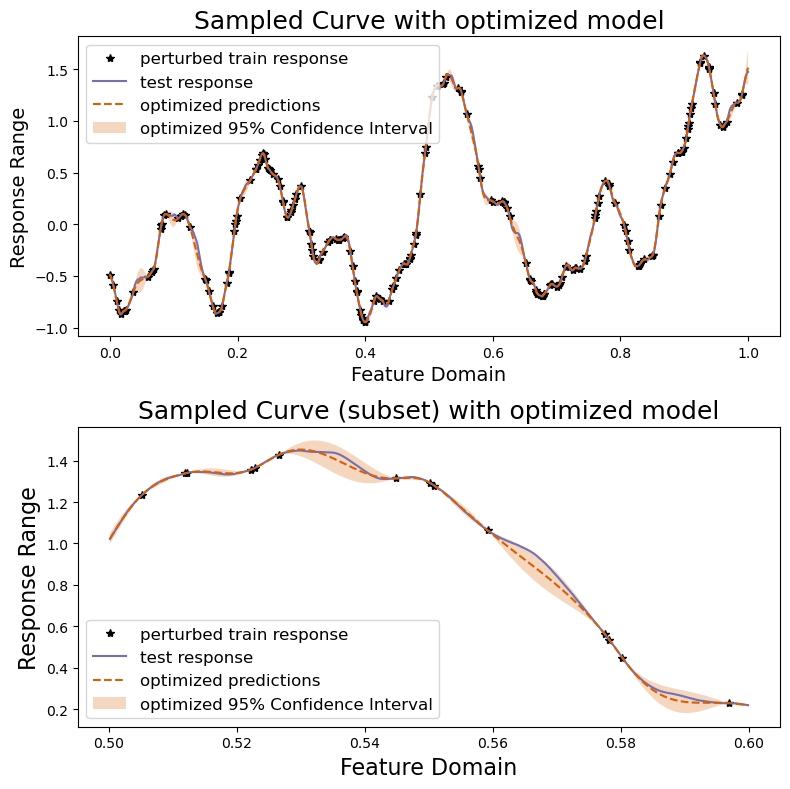

In [30]:
# print results of prediction
variances = muygps_optimized.posterior_variance(Kin, Kcross)
confidence_intervals = np.sqrt(variances) * 1.96
coverage = np.count_nonzero(np.abs(test_responses - predictions) < confidence_intervals) / test_count
print_results(
    test_responses, ("optimized", muygps_optimized, predictions, variances, confidence_intervals, coverage)
)

# plot prediction and confidence intervals
sampler.plot_results(("optimized", predictions, confidence_intervals))